In [5]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import boutdata
from boututils.options import BOUTOptions
from boutdata.collect import create_cache

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

# import sdtools.general.plotstyle
from hermes3.utils import *

from hermes3.fluxes import *

from hermes3.load import *
from hermes3.case_db import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

import time as tm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
db = CaseDB()
toload = [
    dict(name="rnn_10.0", id="d16gh-rnn_10.0"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Reading case d16gh-rnn_10.0
-----------------------
- Looking for squash file
- Squash file found. squash date 09/07/2023, 17:28:47, dmp file date 09/04/2023, 00:17:41



In [3]:
path = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\st40\d16gh-rnn_10.0"


In [12]:
plot = True
save = False
table = False

In [31]:
tstart = tm.time()
    
if path == ".":
    casename = os.path.basename(os.getcwd())
else:
    casename = os.path.basename(path)
print(f"Reading {casename}")
print("Calculating...", end = "")

# Reading with cache for extra speed
cache = create_cache(path, "BOUT.dmp")
print("..cache", end="")
def get_var(name):
    return  boutdata.collect(
        name,
        path = path,
        yguards = True,  # Akways with guards to minimise mistakes
        xguards = True,  # Always with guards to minimise mistakes
        strict = True,   # To prevent reading wrong variable by accident
        info = False,
        datafile_cache = cache
    ).squeeze()

# Get normalisations and geometry
Nnorm = get_var("Nnorm")
Tnorm = get_var("Tnorm")
Omega_ci = get_var("Omega_ci")
MYG = get_var("MYG")
ixseps1 = get_var("ixseps1")
jyseps1_2 = get_var("jyseps1_2")
jyseps2_2 = get_var("jyseps2_2")
ny_inner = get_var("ny_inner")
dx = get_var("dx")
dy = get_var("dy")
dz = get_var("dz")
J = get_var("J")

res_raw = {}
res_raw["ddtPe"] = get_var("ddt(Pe)")
res_raw["ddtPi"] = get_var("ddt(Pd+)")
res_raw["ddtPn"] = get_var("ddt(Pd)")
res_raw["ddtNe"] = get_var("ddt(Nd+)")
res_raw["ddtNn"] = get_var("ddt(Nd)")
res_raw["ddtNVi"] = get_var("ddt(NVd+)")
res_raw["ddtNVd"] = get_var("ddt(NVd)")
dv = dx * dy * dz * J

# Get process parameters
t = get_var("t") * (1/Omega_ci) * 1000
Ne = get_var("Ne") * Nnorm
Nn = get_var("Nd") * Nnorm
Te = get_var("Te") * Tnorm
Tn = get_var("Td") * Tnorm

# Get solver parameters
wtime = get_var("wtime")
nliters = get_var("cvode_nliters")
nniters = get_var("cvode_nniters")
nfails = get_var("cvode_num_fails")
lorder = get_var("cvode_last_order")

print("..data", end="")

Reading d16gh-rnn_10.0
Calculating.....cache..data

In [39]:
# Calculate locations
# [t, x, y]
j2_2g = jyseps2_2 + MYG * 3
j1_2g = jyseps1_2 + MYG * 3
y_omp = int((j2_2g - j1_2g) / 2) + j1_2g
x_sep = ixseps1
x_ng = slice(2,-2)   # No guards in  X

# First row of plots
Ne_sep = Ne[:,x_sep,y_omp]
# Ntot = ((Ne[:, x_ng, :] + Nn[:, x_ng, :]) * dv).sum(axis = (1,2))
Ne_target = np.max((0.5*(Ne[:,x_ng, -2] + Ne[:,x_ng,-3])), axis = 1)
Nn_target = np.max((0.5*(Nn[:,x_ng, -2] + Nn[:,x_ng,-3])), axis = 1)
Tn_target = np.max((0.5*(Tn[:,x_ng, -2] + Tn[:,x_ng,-3])), axis = 1)
Tn_sol = Tn[:, -3, y_omp]

def append_first(x):
    return np.insert(x,0,x[0])
# Second row of plots
stime = np.diff(t, prepend = t[0]*0.99)
wtime_per_stime = wtime/stime
lratio = np.diff(nliters, prepend=nliters[1]*0.99) / np.diff(nniters, prepend=nniters[1]*0.99)   # Ratio of linear to nolinear iterations
fails = np.diff(nfails, prepend = nfails[1]*0.99)
fails[0] = fails[1]
lorder[0] = lorder[1]
wtime_per_stime[0] = wtime_per_stime[1]

# ddt
# TIME / X / Y
guards_inner_upper = slice(ny_inner + MYG, ny_inner + MYG * 2)
guards_outer_upper = slice(ny_inner + MYG * 2, ny_inner + MYG * 3)


res = res_raw.copy()
for param in res:

    for tind in range(res[param].shape[0]):
        res[param][tind,:,:] = (res[param][tind,:,:] * dv) / np.sum(dv)   # Volume weighted
        
    res[param][:,np.r_[0:2,-2:0],:] = 0   # Take out X guards
    res[param][:,:,guards_inner_upper] = 0  # Take out outer Y guards
    res[param][:,:,guards_outer_upper] = 0  # Take out outer Y guards
    
    res[param] = np.sqrt(np.mean(res[param]**2, axis = (1,2)))  # RMS
    res[param] = np.convolve(res[param], np.ones(1), "same")    # Moving average with window of 1
    res[param] = res[param] / res[param][1]

print("..calculations", end="")

..calculations

In [21]:
res[param].shape

(65, 32, 104)

..figures

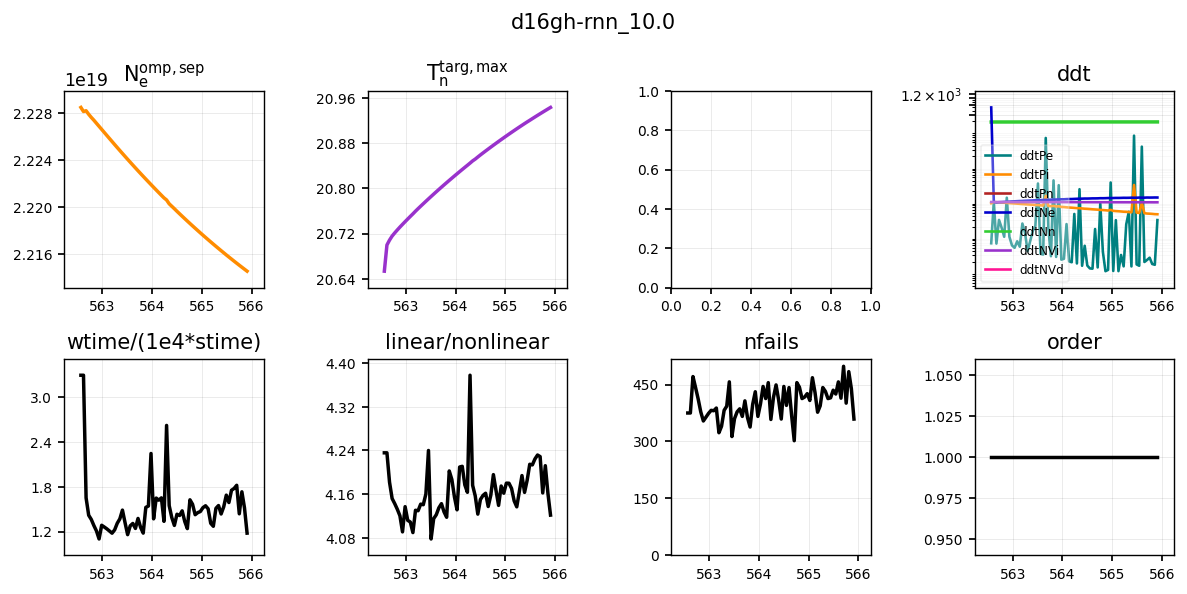

In [40]:
# Plotting
if plot is True or save is True:
    scale = 1.2
    figsize = (8*scale,4*scale)
    dpi = 150/scale
    fig, axes = plt.subplots(2,4, figsize=figsize, dpi = dpi)

    fig.subplots_adjust(hspace=0.4, top = 0.85)
    fig.suptitle(casename)

    lw = 2
    axes[0,0].plot(t, Ne_sep, c = "darkorange", lw = lw)
    axes[0,0].set_title("$N_{e}^{omp,sep}$")
    # axes[0,1].plot(t, Ne_target, c = "darkorchid", lw = lw)
    # axes[0,1].set_title("$N_{e}^{targ,max}$")
    axes[0,1].plot(t, Tn_target, c = "darkorchid", lw = lw)
    axes[0,1].set_title("$T_{n}^{targ,max}$")
    axes[0,3].plot(t, Tn_sol, c = "limegreen", lw = lw)
    axes[0,3].set_title("$T_{n}^{omp,sol}$")
    # axes[0,2].plot(t, Nn_target, c = "deeppink", lw = lw)
    # axes[0,2].set_title("$N_{n}^{targ,max}$")
    
    for param in res:
        axes[0,3].plot(t, res[param], label = param)
    axes[0,3].set_title("ddt")
    axes[0,3].legend(fontsize="x-small")
    axes[0,3].set_yscale("log")
        
    axes[1,0].plot(t, wtime_per_stime/1e4, c = "k", lw = lw)
    axes[1,0].set_title("wtime/(1e4*stime)")
    # axes[1,0].set_yscale("log")
    axes[1,1].plot(t, lratio, c = "k", lw = lw)
    axes[1,1].set_title("linear/nonlinear")
    axes[1,2].plot(t, np.clip(fails, 0, np.max(fails)), c = "k", lw = lw)
    axes[1,2].set_title("nfails")
    axes[1,2].set_ylim(0,None)
    # axes[1,2].set_yscale("log")
    axes[1,3].plot(t, lorder, c = "k", lw = lw)
    axes[1,3].set_title("order")

    for i in [0,1]:
        for ax in axes[i,:]:
            ax.grid(c = "k", alpha = 0.15)
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=3, nbins=5))
            ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=3, nbins=5))
            # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
            ax.tick_params(axis='x',labelsize=8)
            ax.tick_params(axis='y',labelsize=8)
            
    fig.tight_layout()
    
    print("..figures", end="")
    
    if plot is True:
        plt.show()  
        
    if save:
        fig.savefig(f"mon_{casename}.png")
        print("..saved figures", end="")

In [ ]:
omp = ds.hermesm.select_region("outer_midplane_a")
omp.coords

In [64]:
import time
time.time()

1694281925.2344928

In [70]:
nfails

BoutArray([    0,   375,   846,  1288,  1700,  2078,  2432,  2796,  3170,
            3552,  3933,  4321,  4644,  4984,  5366,  5759,  6216,  6529,
            6889,  7267,  7653,  8019,  8426,  8789,  9127,  9525,  9956,
           10322, 10721, 11166, 11579, 12034, 12392, 12808, 13257, 13666,
           14025, 14470, 14865, 15307, 15675, 15977, 16432, 16875, 17288,
           17705, 18131, 18539, 19007, 19436, 19813, 20207, 20649, 21081,
           21494, 21909, 22344, 22769, 23226, 23640, 24138, 24539, 25023,
           25462, 25821])

In [69]:
lratio = np.diff(nliters, prepend=nliters[1]) / np.diff(nniters, prepend=nniters[1])   # Ratio of linear to nolinear iterations
lratio

array([4.23574211, 4.23574211, 4.18198382, 4.15207694, 4.14275371,
       4.13238401, 4.12054605, 4.0910299 , 4.13722131, 4.11220137,
       4.10907123, 4.08973187, 4.1305822 , 4.1297381 , 4.14186191,
       4.14080331, 4.16034576, 4.23998353, 4.0780666 , 4.11524077,
       4.12237643, 4.13508872, 4.14265104, 4.12754834, 4.11776528,
       4.20255707, 4.18693195, 4.15492164, 4.1313957 , 4.20973151,
       4.21101338, 4.17698253, 4.16346022, 4.37770235, 4.17630792,
       4.15699614, 4.12351795, 4.15023162, 4.15779326, 4.1617652 ,
       4.13745709, 4.15816622, 4.19585163, 4.16711116, 4.13950341,
       4.17499481, 4.16181086, 4.18024067, 4.18005654, 4.17046484,
       4.14779783, 4.13687093, 4.16525172, 4.19411891, 4.1632828 ,
       4.18544591, 4.21475773, 4.21358285, 4.22447939, 4.23169281,
       4.22880255, 4.16233447, 4.21213226, 4.16165348, 4.12172007])

In [67]:
np.diff(nliters, prepend=nliters[0])

array([     0, 819794, 410859, 357444, 343310, 322702, 304257, 277065,
       323630, 318087, 311332, 299716, 292375, 303862, 325803, 340726,
       370121, 329434, 286945, 319104, 327024, 310632, 344565, 314222,
       295042, 382937, 387421, 560474, 341150, 411737, 404531, 411792,
       333489, 666816, 391153, 350123, 323791, 361950, 357986, 373739,
       332635, 308748, 405185, 390625, 354772, 361947, 365973, 380381,
       387416, 377352, 329331, 318779, 378763, 389382, 359462, 382307,
       422226, 396949, 438991, 444789, 455848, 363659, 438980, 384079,
       297040])

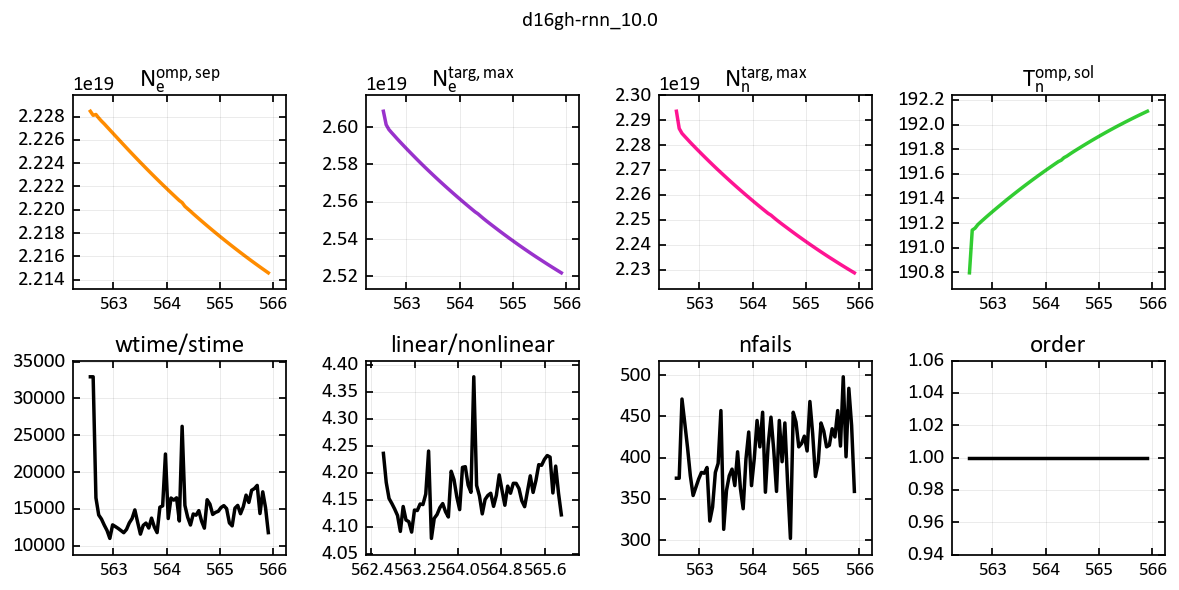

it |  t[ms] |    Nsep      Nseprate |   Ntarg   |   Nntarg  | Tnsol | w/s time | l/n |  nfails  | order |


In [53]:
plt.style.use(r"C:\Users\mikek\OneDrive\Project\python-packages\sdtools\general\mike.mplstyle")

# Calculate locations
# [t, x, y]
j2_2g = jyseps2_2 + MYG * 3
j1_2g = jyseps1_2 + MYG * 3
y_omp = int((j2_2g - j1_2g) / 2) + j1_2g
x_sep = ixseps1
x_ng = slice(2,-2)   # No guards in  X

# First row of plots
Ne_sep = Ne[:,x_sep,y_omp]
Ntot = ((Ne[:, x_ng, :] + Nn[:, x_ng, :]) * dv).sum(axis = [1,2])
Ne_target = np.max((0.5*(Ne[:,x_ng, -2] + Ne[:,x_ng,-3])), axis = 1)
Nn_target = np.max((0.5*(Nn[:,x_ng, -2] + Nn[:,x_ng,-3])), axis = 1)
Tn_sol = Tn[:, -3, y_omp]

def append_first(x):
    return np.insert(x,0,x[0])
# Second row of plots
stime = np.diff(t, prepend = t[0])
wtime_per_stime = wtime/stime
lratio = np.diff(nliters, prepend=nliters[0]) / np.diff(nniters, prepend=nniters[0])   # Ratio of linear to nolinear iterationsa
fails = np.diff(nfails, prepend = nfails[0])
fails[0] = fails[1]
lorder[0] = lorder[1]
wtime_per_stime[0] = wtime_per_stime[1]
 
# Plotting
scale = 1.2
figsize = (8*scale,4*scale)
dpi = 150/scale
fig, axes = plt.subplots(2,4, figsize=figsize, dpi = dpi)

fig.subplots_adjust(hspace=0.4, top = 0.85)
fig.suptitle(casename)

lw = 2
axes[0,0].plot(t, Ne_sep, c = "darkorange", lw = lw)
axes[0,0].set_title("$N_{e}^{omp,sep}$")
axes[0,1].plot(t, Ne_target, c = "darkorchid", lw = lw)
axes[0,1].set_title("$N_{e}^{targ,max}$")
axes[0,2].plot(t, Nn_target, c = "deeppink", lw = lw)
axes[0,2].set_title("$N_{n}^{targ,max}$")
axes[0,3].plot(t, Tn_sol, c = "limegreen", lw = lw)
axes[0,3].set_title("$T_{n}^{omp,sol}$")
    
axes[1,0].plot(t, wtime_per_stime, c = "k", lw = lw)
axes[1,0].set_title("wtime/stime")
# axes[1,1].plot(t, lratio, lw = lw, c = "k")
axes[1,1].plot(t, lratio, c = "k", lw = lw)
axes[1,1].set_title("linear/nonlinear")
axes[1,2].plot(t, fails, c = "k", lw = lw)
axes[1,2].set_title("nfails")
axes[1,3].plot(t, lorder, c = "k", lw = lw)
axes[1,3].set_title("order")

for i in [0,1]:
    for ax in axes[i,:]:
        ax.grid(c = "k", alpha = 0.15)
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=3, nbins=5))
        # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
        ax.tick_params(axis='x',labelsize=11)
        
fig.tight_layout()

if noshow is False:
        plt.show()  
    
if save:
    fig.savefig(f"mon_{casename}.png")

### Print table

def pad(x, l):
    num_spaces = l - len(str(x))
    return  str(x)+" "*num_spaces

def pad_minus(x):
    x = f"{x:.3e}"
    pad = "" if x[0] == "-" else " "
    return pad+x


Nseprate = np.diff(Ne_sep, prepend=Ne_sep[0]) / Ne_sep


print(f"it |  t[ms] |    Nsep      Nseprate |   Ntarg   |   Nntarg  | Tnsol | w/s time | l/n |  nfails  | order |")
# print("~"*100)
for i, time in enumerate(t):
    s1=f"{pad(i,2)} | {time:.2f} | {Ne_sep[i]:.3e}  {pad_minus(Nseprate[i])} | {Ne_target[i]:.3e}"
    s2=f" | {Nn_target[i]:.3e} | {Tn_sol[i]:.2f} | {wtime_per_stime[i]:.2e} | {lratio[i]:.1f} | {nfails[i]:.2e} |   {lorder[i]:.0f}   |"
    
    print(s1+s2)

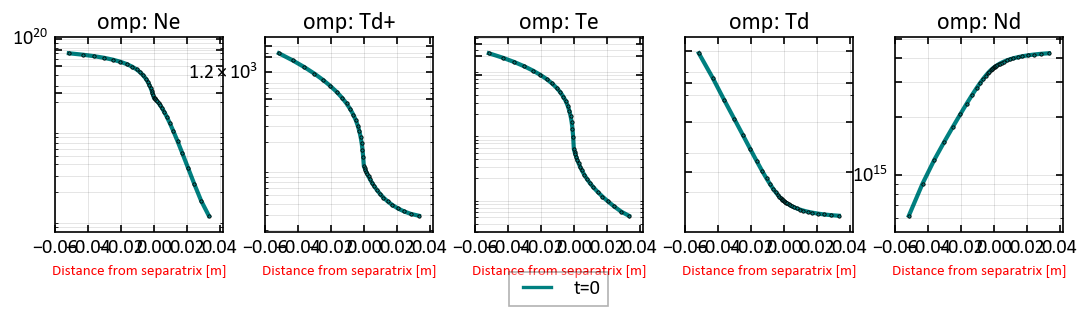

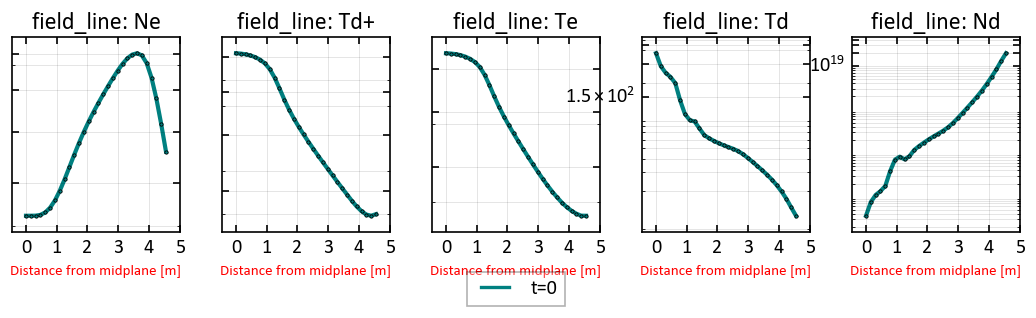

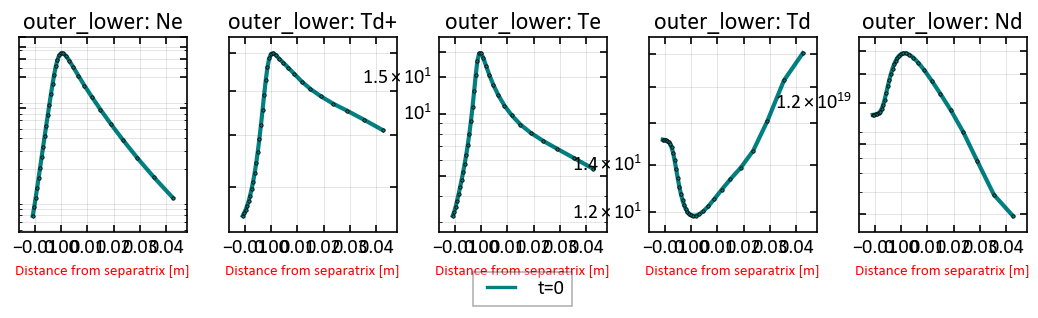

In [43]:
cases = dict()

cases["t=0"] = casestore["rnn_10.0"].ds.isel(t=0, x = slice(2,-2))
# cases["t=-1"] = casestore["base"].ds.isel(t=-1, x = slice(2,-2))

lineplot(
    cases = cases,
    clean_guards = False,
    regions = ["omp", "field_line", "outer_lower"],
    params = ["Ne", "Td+", "Te", "Td", "Nd"],
    # params = ["Pd+", "Pe", "Pd", "NVd+", "NVd"],
)

In [126]:
len(lratio)

64

In [67]:
def pad(x, l):
    num_spaces = l - len(str(x))
    return  str(x)+" "*num_spaces

def pad_minus(x):
    x = f"{x:.3e}"
    pad = "" if "-" in x else " "
    return pad+x

pad_minus(-5.1234e5)

'-5.123e+05'

In [122]:
# Nseprate = np.gradient(Ne_sep, t)
Nseprate = np.insert(np.diff(Ne_sep),0,0) / Ne_sep
wtime_per_stime = np.insert(wtime_per_stime, 0,0)
nfails = np.insert(nfails, 0,0)

print(f"it |  t[ms] |    Nsep      Nseprate |   Ntarg   |   Nntarg  | Tnsol | w/s time | l/n |  nfails  | order |")
# print("~"*100)
for i, time in enumerate(t):
    s1=f"{pad(i,2)} | {time:.2f} | {Ne_sep[i]:.3e}  {pad_minus(Nseprate[i])} | {Ne_target[i]:.3e}"
    s2=f" | {Nn_target[i]:.3e} | {Tn_sol[i]:.2f} | {wtime_per_stime[i]:.2e} | {lratio[i]:.1f} | {nfails[i]:.2e} |   {lorder[i]:.0f}   |"
    
    print(s1+s2)

it |  t[ms] |    Nsep      Nseprate |   Ntarg   |   Nntarg  | Tnsol | w/s time | l/n |  nfails  | order |
0  | 562.57 | 2.092e+19   0.000e+00 | 2.609e+19 | 1.721e+15 | 42.19 | 0.00e+00 | 4.2 | 0.00e+00 |   0   |
1  | 562.62 | 2.090e+19  -9.728e-04 | 2.601e+19 | 1.725e+15 | 42.26 | 0.00e+00 | 4.2 | 0.00e+00 |   1   |
2  | 562.67 | 2.089e+19  -6.667e-04 | 2.599e+19 | 1.726e+15 | 42.28 | 0.00e+00 | 4.2 | 0.00e+00 |   1   |
3  | 562.73 | 2.088e+19  -4.180e-04 | 2.597e+19 | 1.726e+15 | 42.30 | 0.00e+00 | 4.1 | 0.00e+00 |   1   |
4  | 562.78 | 2.087e+19  -4.520e-04 | 2.595e+19 | 1.727e+15 | 42.32 | 0.00e+00 | 4.1 | 0.00e+00 |   1   |
5  | 562.83 | 2.086e+19  -4.215e-04 | 2.594e+19 | 1.727e+15 | 42.33 | 0.00e+00 | 4.1 | 0.00e+00 |   1   |
6  | 562.88 | 2.085e+19  -4.051e-04 | 2.592e+19 | 1.728e+15 | 42.35 | 0.00e+00 | 4.1 | 0.00e+00 |   1   |
7  | 562.93 | 2.085e+19  -4.011e-04 | 2.590e+19 | 1.728e+15 | 42.37 | 0.00e+00 | 4.1 | 0.00e+00 |   1   |
8  | 562.99 | 2.084e+19  -3.879e-04 | 2.589e+1

IndexError: index 64 is out of bounds for axis 0 with size 64

In [39]:
boutdata?

Type:        module
String form: <module 'boutdata' from 'c:\\Users\\mikek\\OneDrive\\Project\\pyenvs\\fusion-a-310\\lib\\site-packages\\boutdata\\__init__.py'>
File:        c:\users\mikek\onedrive\project\pyenvs\fusion-a-310\lib\site-packages\boutdata\__init__.py
Docstring:   Routines for exchanging data to/from BOUT++ 